## Tranfer Learning Part 3 - Scaling up 🍔 Food Vision Mini

We've seen the power of transfer learning feature extraction and fine-tuning. Now it's time to scale up to all of the classes in Food101 (101 total classes of food) and our goal is to beat the original Food101 paper with 10% of the training data, leveraging the power of deep learning 

The Food101 paper got 50.76% accuracy with a Random Forest model 

In [6]:
import tensorflow as tf

In [7]:
!nvidia-smi 

Wed May 29 06:29:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76.01              Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P8             31W /  350W |    1380MiB /  12288MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
print(len(tf.config.list_physical_devices("GPU")))

0


### Creating helper functions 

In [9]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [10]:
# Import series of helper functions for our notebook
from helper_functions import walk_through_dir, unzip_data, plot_loss_curves, create_tensorboard_callback, compare_historys

In [11]:
# Download data for 101 food classes 10% data 
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
# unzip_data("101_food_classes_10_percent.zip")

In [12]:
# How many images/classes are there? 
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250

Keep in mind, you could always use other visualization strategies for the data, like printing out a few random ones at a time 

In [13]:
# Setup data inputs 
IMG_SIZE = (224, 224) 

train_dir_10_percent = "101_food_classes_10_percent/train/" 
test_dir = "101_food_classes_10_percent/test/"

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE, 
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    shuffle = False # don't shuffle test data for prediction analysis later on 
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Train a Big Dog model with transfer learning on 10% of the training data 

Here are the steps we're going to take: 
1. Setup a ModelCheckpoint callback 
2. Create a data augmentation layer to build data augmentation write into the model 
3. Build a headless (no top layers) functional EfficientNetV2B0 backbone model, we'll create our own output layer 
4. Compile our model, then we'll feature extract for 5 full passes (5 epochs on the train dataset and 15% of the test data to save epoch time) 

In [15]:
# Create a Checkpoint callback 
checkpoint_path = "101_food_classes_10_percent_model_checkpoint.weights.h5" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True) 

If you find yourself rewriting a lot of code in your experiments, think about adding it to the helper functions script. That would be cool to make my own yeah 

In [16]:
# Create a data augmentation layer to be incorporated into the model 
from tensorflow.keras.models import Sequential 

# Setup data augmentation 
data_augmentation = Sequential([ 
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomRotation(0.2) 
], name="data_augmentation")

In [17]:
# Create a headless EfficientNet model 
input_shape = (224, 224, 3) 
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False) 
base_model.trainable = False 

# Create input layer and apply data augmentation 
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer") 
x = data_augmentation(inputs) 

# Pass input layer into base model 
x = base_model(x, training=False) # I forgot to add the training part, it is so that the base model keeps the weights frozen 

# Create GlobalAveragePool2D layer 
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) 

# Create output layer 
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x) 

# Create model 
model_0 = tf.keras.Model(inputs, outputs) 

# Compile the model 
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model 
initial_epochs = 5 
history_0 = model_0.fit(train_data_10_percent, 
                        epochs=initial_epochs,
                        validation_data = test_data,
                        validation_steps = int(0.15 * len(test_data)),
                        callbacks = [checkpoint_callback])


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 64s 250ms/step - accuracy: 0.1309 - loss: 4.0737 - val_accuracy: 0.3705 - val_loss: 2.7904
Epoch 2/5
229/237 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.4250 - loss: 2.5853

 50% is not bad for 101 classes right 

In [ ]:
# Evaluate on the whole test dataset 
feature_extraction_results = model_0.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 15s 18ms/step - loss: 1.6077 - accuracy: 0.5785


[1.6077144145965576, 0.5785346627235413]

Already beat the paper :D 

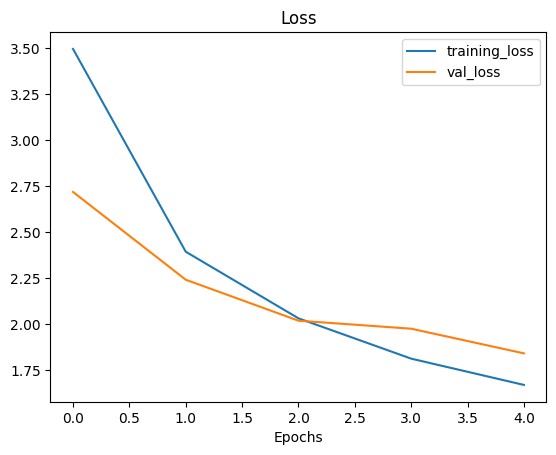

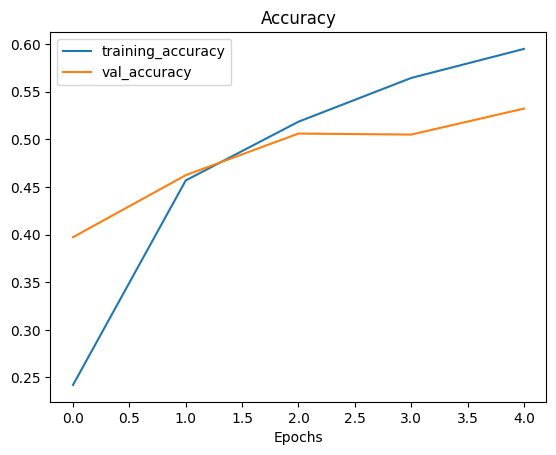

In [ ]:
plot_loss_curves(history_0)

Overfit a bit right? yeah

### Fine Tuning 

In [ ]:
# Unfreeze all of the layers in the base model 
base_model.trainable =  True

# Freeze all but last 5 layers of base model 
for layers in base_model.layers[:-5]:
    layers.trainable = False  

In [ ]:
# Now we have to recompile with a smaller learning rate (10x) 
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# What layers are trainable 
for layer in model_0.layers: 
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling_layer True
output_layer True


In [ ]:
# Check which layers in the base model are trainable 
for layer_number, layers in enumerate(base_model.layers): 
    print(layer_number, layers.name, layers.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [ ]:
# Model 0 with fine tuning 
history_10_percent_fine_tune = model_0.fit(train_data_10_percent, 
                                           epochs=10, 
                                           validation_data=test_data, 
                                           validation_steps=int(0.15 * len(test_data)), 
                                           initial_epoch=history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 145s 595ms/step - loss: 1.4605 - accuracy: 0.6305 - val_loss: 1.8007 - val_accuracy: 0.5257
Epoch 6/10
237/237 [==============================] - 88s 369ms/step - loss: 1.3937 - accuracy: 0.6338 - val_loss: 1.7874 - val_accuracy: 0.5315
Epoch 7/10
237/237 [==============================] - 74s 312ms/step - loss: 1.3167 - accuracy: 0.6502 - val_loss: 1.7731 - val_accuracy: 0.5347
Epoch 8/10
237/237 [==============================] - 60s 250ms/step - loss: 1.2641 - accuracy: 0.6713 - val_loss: 1.7646 - val_accuracy: 0.5336
Epoch 9/10
237/237 [==============================] - 52s 219ms/step - loss: 1.2315 - accuracy: 0.6775 - val_loss: 1.7522 - val_accuracy: 0.5392
Epoch 10/10
237/237 [==============================] - 46s 193ms/step - loss: 1.2103 - accuracy: 0.6828 - val_loss: 1.7787 - val_accuracy: 0.5373


Fine tuning does not always result in improvements 

In [ ]:
all_classes_10_percent_results = model_0.evaluate(test_data) 
all_classes_10_percent_results

790/790 [==============================] - 16s 20ms/step - loss: 1.4738 - accuracy: 0.6029


[1.4737722873687744, 0.6028515100479126]

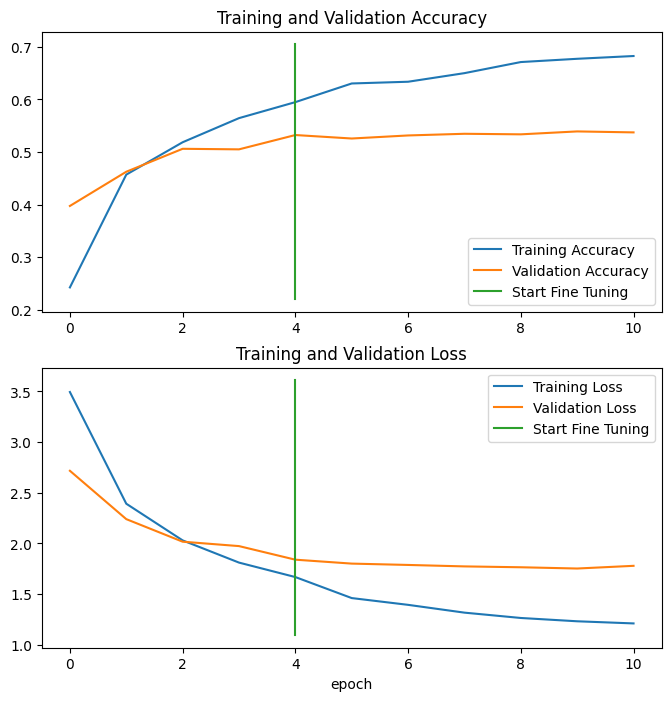

In [ ]:
# Compare the history of feature extraction model with fine tuning model 
compare_historys(history_0, history_10_percent_fine_tune, 5)

This is still overfit, so we can look at some methods for making this more accurate, but for now in the course we are going to move on 

### Save and Load our Model 

In [ ]:
# Saving our fine tuned model 
model_0.save("saved_model/my_model")

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
# Load and evaluate saved model 
loaded_model = tf.keras.models.load_model("saved_model/my_model")

#### These should be very similar evaluations because they are the same value 

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data) 
loaded_model_results

790/790 [==============================] - 17s 20ms/step - loss: 1.4738 - accuracy: 0.6029


[1.4737722873687744, 0.6028515100479126]

In [ ]:
all_classes_10_percent_results

[1.4737722873687744, 0.6028515100479126]

### Evaluating the Performance of the big dog model across all different classes 

let's make predictions, visualize them, and figure out which were the most wrong  

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-02-24 08:10:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.191.155, 142.250.191.187, 142.250.191.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.191.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  31.1MB/s    in 1.4s    

2024-02-24 08:10:28 (31.1 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
import tensorflow as tf
# Load in saved pre-trained model (from the github) 
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just downloaded) on test data 
results_downloaded_model = model.evaluate(test_data) 
results_downloaded_model

2024-02-27 12:17:54.122545: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


790/790 [==============================] - 22s 26ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027193546295166, 0.6077623963356018]

### Making Predictions with our Trained Model 

In [ ]:
# Make predictions with model 
pred_probs = model.predict(test_data, verbose=1) # Set verbose to see how long is left 

790/790 [==============================] - 18s 22ms/step


In [ ]:
# Why 790? 
len(test_data)

790

In [ ]:
790 * 32 # because batches 

25280

In [ ]:
# How many predictions are there? 
len(pred_probs)

25250

In [ ]:
# What is the shape of our predictions? 
pred_probs.shape 

(25250, 101)

In [ ]:
# What does the first prediction look like? 
pred_probs[0]

array([5.9541978e-02, 3.5742457e-06, 4.1377034e-02, 1.0660697e-09,
       8.1615052e-09, 8.6640979e-09, 8.0927970e-07, 8.5652414e-07,
       1.9859339e-05, 8.0977833e-07, 3.1728045e-09, 9.8674116e-07,
       2.8532447e-04, 7.8049789e-10, 7.4230618e-04, 3.8916674e-05,
       6.4741357e-06, 2.4977685e-06, 3.7891023e-05, 2.0678367e-07,
       1.5538526e-05, 8.1508267e-07, 2.6230516e-06, 2.0010724e-07,
       8.3828172e-07, 5.4216343e-06, 3.7391248e-06, 1.3150558e-08,
       2.7761417e-03, 2.8052131e-05, 6.8562678e-10, 2.5574904e-05,
       1.6689056e-04, 7.6408169e-10, 4.0453358e-04, 1.3150809e-08,
       1.7957567e-06, 1.4448340e-06, 2.3062756e-02, 8.2467642e-07,
       8.5365531e-07, 1.7138627e-06, 7.0525703e-06, 1.8402272e-08,
       2.8553319e-07, 7.9485126e-06, 2.0681650e-06, 1.8525257e-07,
       3.3620218e-08, 3.1522417e-04, 1.0410962e-05, 8.5448113e-07,
       8.4741861e-01, 1.0555445e-05, 4.4094205e-07, 3.7404105e-05,
       3.5306261e-05, 3.2489192e-05, 6.7314999e-05, 1.2852615e

Our model outputs a prediction probability array with N number of variables where N = the number of classes for each sample passed to the predict method.  

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}\n")
print(f"Class with the highest predicted probability: {test_data.class_names[pred_probs[0].argmax()]}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541978e-02 3.5742457e-06 4.1377034e-02 1.0660697e-09 8.1615052e-09
 8.6640979e-09 8.0927970e-07 8.5652414e-07 1.9859339e-05 8.0977833e-07
 3.1728045e-09 9.8674116e-07 2.8532447e-04 7.8049789e-10 7.4230618e-04
 3.8916674e-05 6.4741357e-06 2.4977685e-06 3.7891023e-05 2.0678367e-07
 1.5538526e-05 8.1508267e-07 2.6230516e-06 2.0010724e-07 8.3828172e-07
 5.4216343e-06 3.7391248e-06 1.3150558e-08 2.7761417e-03 2.8052131e-05
 6.8562678e-10 2.5574904e-05 1.6689056e-04 7.6408169e-10 4.0453358e-04
 1.3150809e-08 1.7957567e-06 1.4448340e-06 2.3062756e-02 8.2467642e-07
 8.5365531e-07 1.7138627e-06 7.0525703e-06 1.8402272e-08 2.8553319e-07
 7.9485126e-06 2.0681650e-06 1.8525257e-07 3.3620218e-08 3.1522417e-04
 1.0410962e-05 8.5448113e-07 8.4741861e-01 1.0555445e-05 4.4094205e-07
 3.7404105e-05 3.5306261e-05 3.2489192e-05 6.7314999e-05 1.2852615e-08
 2.6219807e-10 1.0318207e-05 8.5743704e-05 1.

In [ ]:
# Get the pred classes of each label 
pred_classes = pred_probs.argmax(axis=1) 

# How do they look? 
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have 
len(pred_classes)

25250

So now we have a prediction index for each sample? :O 

Now we need to compare them to the original labels 

In [ ]:
# To get our test labels we have to unravel our test data batch dataset. 
y_label = [] 
for images, labels in test_data.unbatch(): 
    y_label.append(labels.numpy().argmax())

# Look at the first 10 
y_label[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y labels are there 
len(y_label)

25250

In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

### Evaluating our models' predictions 

One way to check that our models' predictions array is in the same order as our test labels array is to find the accuracy score. 

In [ ]:
results_downloaded_model

[1.8027193546295166, 0.6077623963356018]

In [ ]:
# Let's try scikitlearn's accuracy score function to see what it comes up with 
from sklearn.metrics import accuracy_score
sklearn_acc = accuracy_score(y_true=y_label, y_pred=pred_classes) 
sklearn_acc

0.6077623762376237

In [ ]:
# Just to double check for fun 
import numpy as np 
np.isclose(results_downloaded_model[1], sklearn_acc)

True

### Let's Get Visual: Making Our Confusion Matrix 

In [ ]:
# Get a list of class names 
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# We need to make some changes to the make confusion matrix function so that the xlabels print vertically 
import matplotlib.pyplot as plt 
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ###  Make x-labels appear vertically (Changed) ###
  plt.xticks(rotation=70, fontsize=text_size) 
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_label, y_pred=pred_classes, classes=class_names, figsize=(100, 100), text_size=25, savefig=True)

### Let's keep the evaluation going, time for a classification report 

Sci-kit learn has a helpful function for acquiring many different classification metrics per class (e.g. percision, recall, and F1) called classification_report. Let's try it out 

In [ ]:
from sklearn.metrics import classification_report 
print(classification_report(y_true=y_label, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The above is the following evaluation metrics for each specific class were 1 = perfect and 0 = terrible. As we can see, our model does well on some classes but kind of poorly on others 

Let's make a pretty picture to get a better understanding :D 

In [ ]:
# Get a dictionary of the classification report 
classification_report_dict = classification_report(y_label, pred_classes, output_dict=True) 
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.5440806045340051,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.4186046511627907,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

Let's plot all classes f1 scores 

In [ ]:
# Create empty dictionary 
class_f1_score = {} 
# Loop through classification report dict items 
for k, v in classification_report_dict.items():
    if k == "accuracy": # Stop once we get to this part of the dict 
        break 
    else: 
        # Add class names and f1 scores to new dictionary 
        class_f1_score[class_names[int(k)]] = v["f1-score"] 

class_f1_score

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5440806045340051,
 'beet_salad': 0.4186046511627907,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056105,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.46255506607929514,
 'creme_brulee'

pag 

In [ ]:
# Turn f1-scores into dataframe for visualization 
import pandas as pd 

f1_score = pd.DataFrame({"class_names": list(class_f1_score.keys()),
                         "f1-score": list(class_f1_score.values())}).sort_values("f1-score", ascending=False)

f1_score[:10]


class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

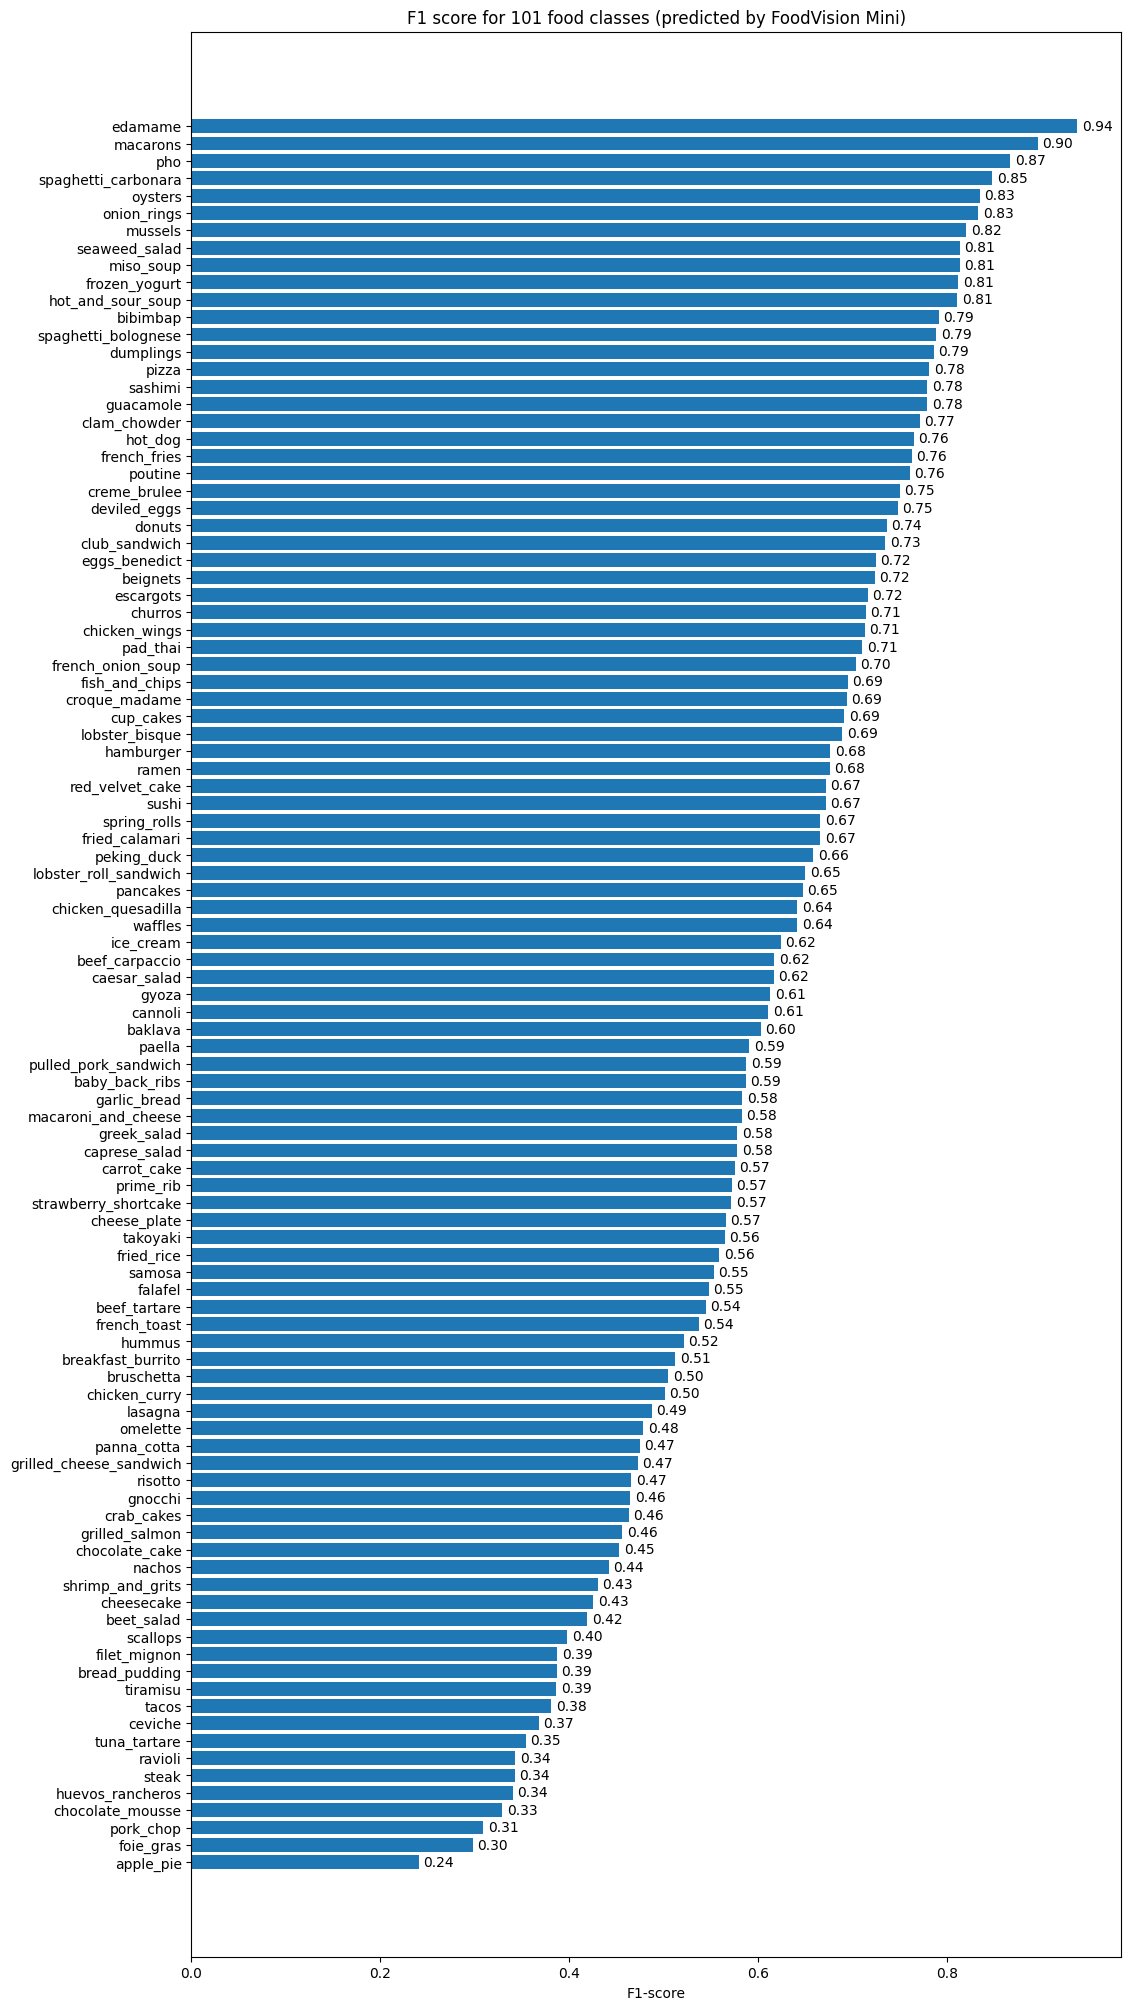

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25)) 
scores = ax.barh(range(len(f1_score)), f1_score["f1-score"].values) # Get the f1-score values 
ax.set_yticks(range(len(f1_score))) 
ax.set_yticklabels(f1_score["class_names"]);
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 food classes (predicted by FoodVision Mini)")
ax.invert_yaxis(); # Reverse the order of our plot 

# Challenge - add values to the end of each bar of what the actual f1 score is 
for bar in scores:
    width = bar.get_width()  # Get the width of the bar (the F1 score)
    label_x_pos = width + ax.get_xlim()[1] * 0.005  # Slightly right of the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center')


Let's try to visualize some of our poorly performed classes and see if we can find any patterns on why they may be performing so poorly 


### Visualizing Predictions on Custom Images 

Now, this is the real challenge. How does our model go on food images that are not even in the test dataset? (Images of our own --> we will do this later) 

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to: 
- Read in a target image file path using tf.io.read_file 
- Turn the image into a Tensor using tf.io.decode_image 
- Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize 
- Scale the image to get all of the pixel values between 0 and 1 (if necessary --> efficientnet already does this) 
  

In [ ]:
# Create a function to load and prepare images 
def load_and_prep_image(filename, image_shape=224, scale=True): 
    """ 
    Reads in an image from filename, turns it into a tensor and reshapes into specified shape. (image_shape, image_shape, 3) 

    Args: 
        filename (str): path to target image 
        image_shape (int): height/width dimension of target image size 
        scale (bool): Scale pixel values from 0 to 225 --> 0 to 1 or not 

    Returns: 
        Image tensor of shape (image_shape, image_shape, 3)  
    """

    # Read in the target image 
    img = tf.io.read_file(filename) 

    # Decode image into tensor 
    img = tf.io.decode_image(img, channels=3) # Apparently png is 4 color channels so for our model we need to hard code it to be 3 

    # Resize the image 
    img = tf.image.resize(img, [image_shape, image_shape])

    # Scale? 
    if scale: 
        return img / 255. 
    else: 
        return img 

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label, and our model's prediction 

Specifically, we'll write some code to: 
- Load a few random images from the test dataset 
- Make predictions on the loaded images 
- Plot the original images along with the model's predictions, prediction probability, and truth label 

1/1 [==============================] - 0s 15ms/step


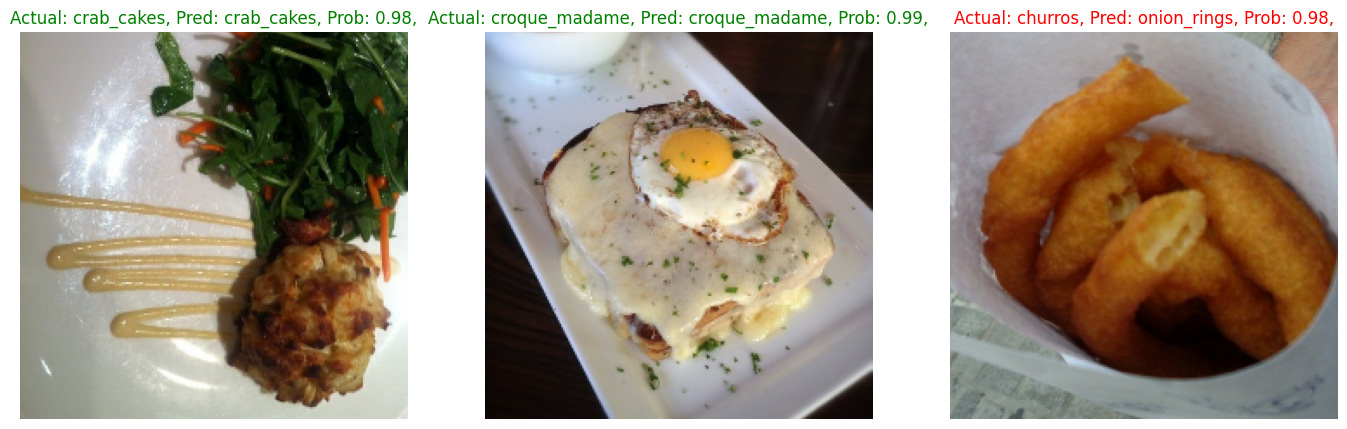

In [ ]:
# Make preds on a series of random images 
import os 
import random 

plt.figure(figsize=(17, 10)) 
for i in range(3): 
    # Choose random images from a random classes 
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load image and make predictions 
    img = load_and_prep_image(filepath, scale=False) 
    pred_prob = model.predict(tf.expand_dims(img, axis=0 )) # Get prediction probabilities array --> look at notes below for note 1 
    pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index 
    # print(pred_prob) 
    # print(pred_class) 

    # Plot the images 
    plt.subplot(1, 3, i+1) 
    plt.imshow(img/255.) 
    if class_name == pred_class: # If predicted class matches truth class, make text green 
        title_color = "g" 
    else: 
        title_color = "r" 
    plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max():.2f},", c=title_color) 
    plt.axis(False); 


Note 1: So our image shapes are (224, 224, 3) but we need them to be (None, 224, 224, 3) because our model is trained in batches so that is why we have to use expand dims 

### Finding the model's most wrong predictions 

We do this by viewing the incorrect predictions with the highest probability/"confidence". This could be beneificial because maybe our labels are wrong and the model was actually correct. If not, it also gives a better understanding on what classes are confusing and how to gather better data 

We will write code to do the following: 
- Get all of the image filepaths in the test dataset using the list_files method 
- Create a pd dataframe of the image file paths, ground truth labels, predicted classes, max prediction probabilities, prediction class names, ground truth class names. 
- Use dataframe to find all of the incorrect predictions 
- Sort the dataframe based on wrong predictions with the highest prediction probability at the top 
- Visualize the images with the highest prediction probability but have the wrong prediction  

In [ ]:
# Get all of the image filepaths in the test dataset 
filepaths = [] 
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy()) 

In [ ]:
# Create a dataframe of different parameters for each of our test images 
pred_df = pd.DataFrame({"image_path": filepaths,
                        "y_true": y_label,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_class_names": [class_names[i] for i in y_label],
                        "y_pred_class_names": [class_names[i] for i in pred_classes]}) 
pred_df

image_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_class_names    y_pred_class_names  
0       0.847419          apple_pie                 gyoza  
1       0.964017          apple_pie             apple_pie  
2       0.959259          apple_pie             apple_pie  
3       0.658605          apple_pie  pulled_pork_sandwich  
4       0.367903          apple_pie             prime_rib  
...          ...                ...                   ...  
25245   0.972823            waffles               waffles  
25246   0.878028            waffles          cheese_plate  
25247   0.537899            waffles               waffles  
25248   0.501949            waffles  strawberry_shortcake  
25249   0.690628            waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# Find which predictions are wrong in our dataframe 
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head() 

image_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_class_names    y_pred_class_names  pred_correct  
0   0.847419          apple_pie                 gyoza         False  
1   0.964017          apple_pie             apple_pie          True  
2   0.959259          apple_pie             apple_pie          True  
3   0.658605          apple_pie  pulled_pork_sandwich         False  
4   0.367903          apple_pie             prime_rib         False

In [ ]:
# Sort our dataframe to have most wrong predictions at the top 
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

image_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf     y_true_class_names     y_pred_class_names  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

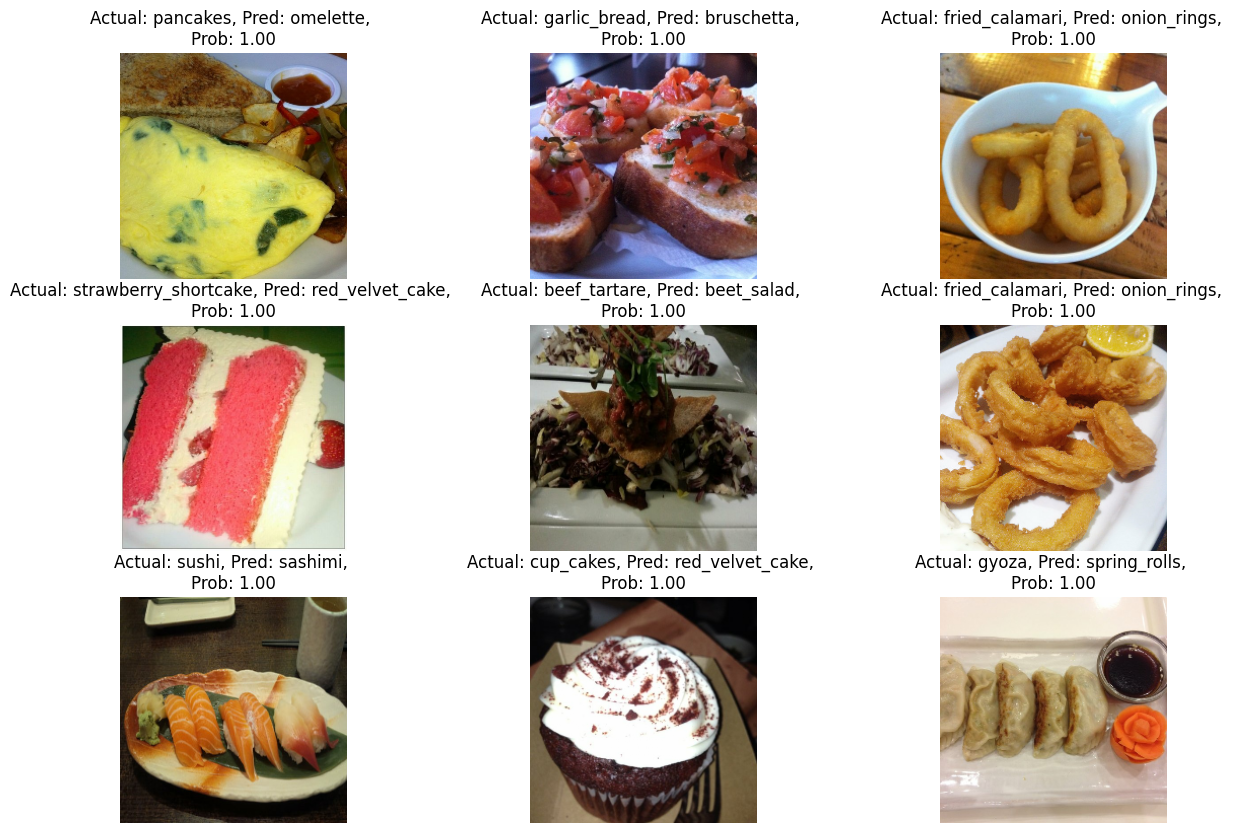

In [ ]:
# Visualize test samples that have the wrong prediction but highest pred probability 
image_to_view = 9 
start_index = 10 
plt.figure(figsize=(15, 10)) 
for i, row in enumerate(top_100_wrong[start_index:start_index+image_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _, = row # Only interseted in a few parameters of each row 
    plt.imshow(img/255.) 
    plt.title(f"Actual: {y_true_classname}, Pred: {y_pred_classname}, \nProb: {pred_prob:.2f}")
    plt.axis(False); 

### Testing out the big dog model on custom data 



In [ ]:
# Get custom images 
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
#unzip_data("custom_food_images.zip")

In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/taco.jpg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 17ms/step


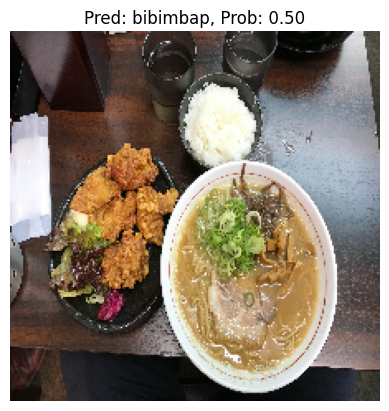

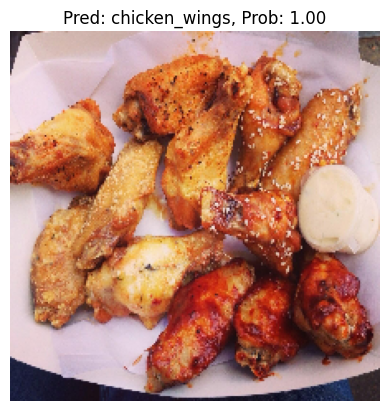

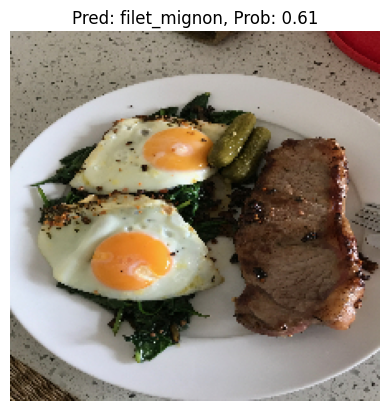

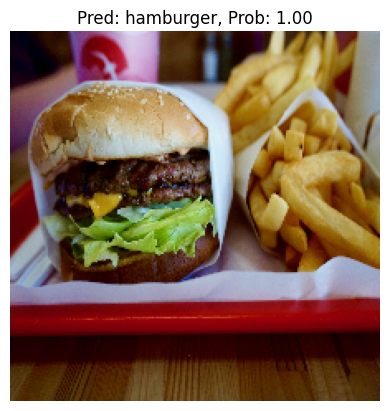

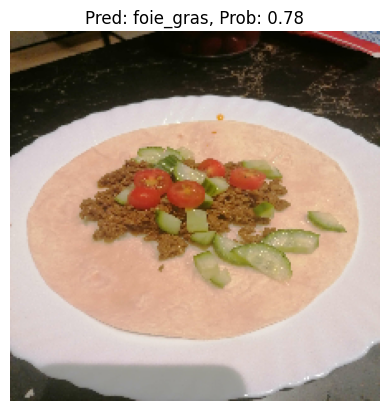

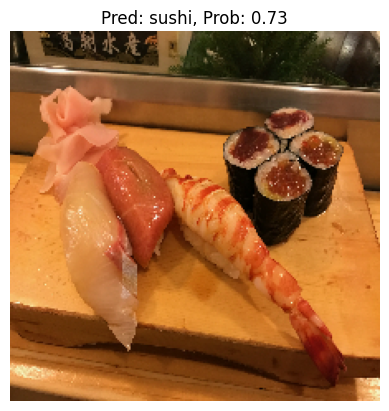

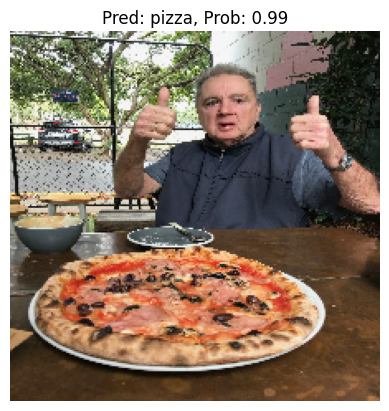

In [ ]:
# Make predictions on and plot custom food images 
for img in custom_food_images: 
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]

    # Plot the appropriate information 
    plt.figure() 
    plt.imshow(img/255.) 
    plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max():.2f}")
    plt.axis(False);  